In [1]:
'''
   1) compute mean Tanimoto similarity historgrams for database molecules vs Logan's molecules
      (show max for Logan's as well)
   2) figure out how to average the output from MPNN and save the tensor
   3) train one-shot architecture to give similarity index
'''

"\n   1) compute mean Tanimoto similarity historgrams for database molecules vs Logan's molecules\n      (show max for Logan's as well)\n   2) figure out how to average the output from MPNN and save the tensor\n   3) train one-shot architecture to give similarity index\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

# Tanimoto similarity imports
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, MolToSmiles, RDKFingerprint
from rdkit.Chem import Descriptors, QED, rdmolops

# MPNN imports
import json
from tensorflow.keras.models import load_model
from molgym.envs.rewards.mpnn import MPNNReward
from molgym.mpnn.layers import custom_objects
from molgym.utils.conversions import convert_rdkit_to_nx

# Tanimoto Similarity

In [3]:
# load database and clean/delete duplicates
db='protease_only_id_smiles_IC50' 
df = pd.read_csv(f'../notebooks/{db}.csv')
df = df[df['IC50'].notna()]
df['IC50'] = df['IC50'].apply(lambda x: float(str(x).replace('>','').replace('<','')))
df=df.drop_duplicates(subset=['InChI'],keep='first')
print(f'{len(df)} molecules in database')

# get list of smiles
smiles=df['InChI'].tolist()

# get mol objects and fingerprints 
ms_db = [MolFromSmiles(x) for x in df['InChI'].tolist()]
fps_db = [RDKFingerprint(x) for x in ms_db]

6545 molecules in database


In [4]:
def similarity_search(fps_db, smile, returntype='mean'):
    fps_test = RDKFingerprint(MolFromSmiles(smile))
    ts=[]
    for i, s_top in enumerate(fps_db):
        ts.append(DataStructs.FingerprintSimilarity(s_top, fps_test))
    
    if returntype=='mean':
        ts=np.array(ts)
        return ts.mean()
    elif returntype=='max':
        ts=np.array(ts)
        return ts.max()
    elif returntype=='max-1':
        ts.sort(reverse=True)
        ts=np.array(ts[1:])
        return ts.max()
    else:
        return None

In [5]:
db_similarity=[]
for smile in df['InChI'].tolist():
    db_similarity.append(similarity_search(fps_db, smile, returntype='mean'))
print(f'{len(db_similarity)} molecules searched')

6545 molecules searched


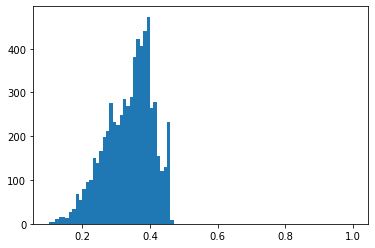

In [6]:
bins=[x/100 for x in range(10,101)]
plt.hist(db_similarity,bins=bins)
plt.show()

# One-shot Similarity

In [7]:
# stop warnings from showing up
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [11]:
from molgym.mpnn.layers import GraphNetwork, Squeeze
from molgym.mpnn.data import make_data_loader
from molgym.mpnn.data import convert_nx_to_dict
from molgym.utils.conversions import convert_rdkit_to_nx

from rdkit.Chem import MolFromSmiles
from rdkit import Chem

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks as cb
from tensorflow.keras.initializers import RandomUniform
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr, kendalltau
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os.path as op
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple
import random

#from molgym.mpnn.data import convert_nx_to_dict
from molgym.utils.conversions import convert_smiles_to_nx
from molgym.mpnn.data import make_tfrecord

In [12]:
# uniqe identifier for saved files
dataid=''

# load clean database 
db='protease_only_id_smiles_IC50'  
df = pd.read_csv(f'../notebooks/{db}_deduped.csv')
df=df.sort_values('pIC50', ascending=False)

# remove metals
df=df.loc[(df['smiles'].str.contains('Cu')==False)&(df['smiles'].str.contains('Co')==False)&(df['smiles'].str.contains('Mn')==False)&(df['smiles'].str.contains('Ni')==False)]
print(f'{len(df)} molecules in database')

# get list of smiles
smiles=df['smiles'].tolist()

df.head()

6542 molecules in database


,pIC50,pIC50_std,smiles
5168,10.886057,NaN,CC(C)(C)NC(=O)[C@@H]1CN(CCN1C[C@@H](O)C[C@@H](...
67,10.823909,NaN,CC(C)(C)NC(=O)[C@@H]1CN(CCN1C[C@@H](O)C[C@@H](...
1588,10.823909,NaN,Cc1nnc(C[C@H](C[C@H](O)CN2CCN(Cc3ccc(o3)-c3ccc...
5563,10.823909,NaN,CCCc1nnc(C[C@H](C[C@H](O)CN2CCN(Cc3ccc(o3)-c3c...
743,10.721246,NaN,O[C@@H](C[C@@H](Cc1nnc(o1)-c1ccccc1)C(=O)N[C@@...


In [13]:
# load dissimilar dataset

ds=pd.read_csv('nullmols.csv')
null_smiles=ds['smiles'].tolist()
print(f'{len(null_smiles)} dissimilar molecules')

4455 dissimilar molecules


In [14]:
# if null dataset contains the same atom and bond types load types

mpnn_dir='../notebooks/mpnn-training/'
    
with open(op.join(mpnn_dir, 'atom_types.json')) as fp:
    atom_types = json.load(fp)
    atom_type_count = len(atom_types)
with open(op.join(mpnn_dir, 'bond_types.json')) as fp:
    bond_types = json.load(fp)
    bond_type_count = len(bond_types)
    

In [16]:
# if null dataset contains new atoms or bond types make atom and bond types from scratch

from molgym.mpnn.data import make_type_lookup_tables
df['nx'] = df['smiles'].apply(convert_smiles_to_nx)
atom_types, bond_types = make_type_lookup_tables(df['nx'].tolist())
atom_type_count = len(atom_types)
bond_type_count = len(bond_types)

# save for future use
with open('atom_types.json', 'w') as fp:
    json.dump(atom_types, fp)
    
with open('bond_types.json', 'w') as fp:
    json.dump(bond_types, fp)
    


In [17]:
def convert_nxs_to_dicts(graph_l: nx.Graph, graph_r: nx.Graph, atom_types: List[int], bond_types: List[str]) -> dict:
    """Convert networkx representation of molecule pair to an MPNN-ready dict
    Args:
        graph_l and graph_r: Molecules to be converted
        atom_types: Lookup table of observed atom types
        bond_types: Lookup table of observed bond types
    Returns:
        (dict) Molecule pair as a dict
    """
    
    # Get the atom types for _l
    atom_type_l = [n['atomic_num'] for _, n in graph_l.nodes(data=True)]
    atom_type_id_l = list(map(atom_types.index, atom_type_l))
    # Get the atom types for _r
    atom_type_r = [n['atomic_num'] for _, n in graph_r.nodes(data=True)]
    atom_type_id_r = list(map(atom_types.index, atom_type_r))

    # Get the bond types for _l, making the data
    connectivity_l = []
    edge_type_l = []
    for a, b, d in graph_l.edges(data=True):
        connectivity_l.append([a, b])
        connectivity_l.append([b, a])
        edge_type_l.append(str(d['bond_type']))
        edge_type_l.append(str(d['bond_type']))
    edge_type_id_l = list(map(bond_types.index, edge_type_l))
    # Get the bond types for _r, making the data
    connectivity_r = []
    edge_type_r = []
    for a, b, d in graph_r.edges(data=True):
        connectivity_r.append([a, b])
        connectivity_r.append([b, a])
        edge_type_r.append(str(d['bond_type']))
        edge_type_r.append(str(d['bond_type']))
    edge_type_id_r = list(map(bond_types.index, edge_type_r))

    # Sort connectivity array by the first column
    #  This is needed for the MPNN code to efficiently group messages for
    #  each node when performing the message passing step
    connectivity_l = np.array(connectivity_l)
    if connectivity_l.size > 0:
        # Skip a special case of a molecule w/o bonds
        inds = np.lexsort((connectivity_l[:, 1], connectivity_l[:, 0]))
        connectivity_l = connectivity_l[inds, :]

        # Tensorflow's "segment_sum" will cause problems if the last atom
        #  is not bonded because it returns an array
        assert connectivity_l.max() == len(atom_type_l) - 1, "Problem with unconnected atoms for {}"
    else:
        connectivity_l = np.zeros((0, 2))
        
    # Sort connectivity array by the first column
    #  This is needed for the MPNN code to efficiently group messages for
    #  each node when performing the message passing step
    connectivity_r = np.array(connectivity_r)
    if connectivity_r.size > 0:
        # Skip a special case of a molecule w/o bonds
        inds = np.lexsort((connectivity_r[:, 1], connectivity_r[:, 0]))
        connectivity_r = connectivity_r[inds, :]

        # Tensorflow's "segment_sum" will cause problems if the last atom
        #  is not bonded because it returns an array
        assert connectivity_r.max() == len(atom_type_r) - 1, "Problem with unconnected atoms for {}"
    else:
        connectivity_r = np.zeros((0, 2))

    return {
        'n_atom_l': len(atom_type_l),
        'n_bond_l': len(edge_type_l),
        'atom_l': atom_type_id_l,
        'bond_l': edge_type_id_l,
        'connectivity_l': connectivity_l,
        'n_atom_r': len(atom_type_r),
        'n_bond_r': len(edge_type_r),
        'atom_r': atom_type_id_r,
        'bond_r': edge_type_id_r,
        'connectivity_r': connectivity_r
    }

In [18]:
data=pd.DataFrame()

# generate random samples 
n_tot=274
n_samples=int(n_tot/2)

data['smiles_l']=random.sample(smiles, n_samples) + random.sample(smiles, n_samples)
data['smiles_r']=random.sample(smiles, n_samples) + random.sample(null_smiles, n_samples)
data['similarity']=[1.]*n_samples + [0.]*n_samples

# make graphs
data['nx_l'] = data['smiles_l'].apply(convert_smiles_to_nx)
data['nx_r'] = data['smiles_r'].apply(convert_smiles_to_nx)

def df_conversion(l, r, atom_types, bond_types):
    return convert_nxs_to_dicts(l, r, atom_types, bond_types)

data['dict'] = data.apply(lambda x: df_conversion(x.nx_l, x.nx_r, atom_types, bond_types), axis=1)

print(f'{len(data)} pairs generated')

274 pairs generated


In [19]:
# check that no atom types are used that aren't present in atom_types

c=0
for n in range(len(data)):
    al=list(set(nx.get_node_attributes(data.iloc[n]['nx_l'],'atomic_num').values()))
    ar=list(set(nx.get_node_attributes(data.iloc[n]['nx_r'],'atomic_num').values()))
    nodes=al+ar
    if all(elem in atom_types for elem in nodes)==False:
        print(n)
    else:
        c+=1
        
if c==len(data):
    print('Test passed: all graphs contain atoms within atom_types')

Test passed: all graphs contain atoms within atom_types


In [20]:
# create TF records

train_data, test_data = train_test_split(data, test_size=0.05, random_state=1, stratify=data['similarity'])
print(f'Split off {len(test_data)} mols for testing')

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=2, stratify=train_data['similarity'])
print(f'Split remaining mols into a {len(train_data)}/{len(val_data)} split for train and validation')

for path, data in zip([f'train_data{dataid}.proto', f'val_data{dataid}.proto', f'test_data{dataid}.proto'], 
                     [train_data, val_data, test_data]):
    with tf.io.TFRecordWriter(path) as writer:
        for _, entry in data.iterrows():
            record = entry['dict']
            record['similarity'] = entry['similarity']
            writer.write(make_tfrecord(record))

Split off 14 mols for testing
Split remaining mols into a 234/26 split for train and validation


In [21]:
from functools import partial
from typing import List, Tuple

def parse_records(example_proto, target_name: str = 'similarity'):
    """Parse data from the TFRecord

    Args:
        example_proto: Batch of serialized TF records
        target_name (str): Name of the output property
    Returns:
        Batch of parsed TF records
    """
    features = {
        target_name: tf.io.FixedLenFeature([], tf.float32, default_value=np.nan),
        'n_atom_l': tf.io.FixedLenFeature([], tf.int64),
        'n_bond_l': tf.io.FixedLenFeature([], tf.int64),
        'connectivity_l': tf.io.VarLenFeature(tf.int64),
        'atom_l': tf.io.VarLenFeature(tf.int64),
        'bond_l': tf.io.VarLenFeature(tf.int64),
        'n_atom_r': tf.io.FixedLenFeature([], tf.int64),
        'n_bond_r': tf.io.FixedLenFeature([], tf.int64),
        'connectivity_r': tf.io.VarLenFeature(tf.int64),
        'atom_r': tf.io.VarLenFeature(tf.int64),
        'bond_r': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_example(example_proto, features)


def prepare_for_batching(dataset):
    """Make the variable length arrays into RaggedArrays.
    
    Allows them to be merged together in batches"""
    for c in ['atom_l', 'bond_l', 'connectivity_l', 'atom_r', 'bond_r', 'connectivity_r']:
        expanded = tf.expand_dims(dataset[c].values, axis=0, name=f'expand_{c}')
        dataset[c] = tf.RaggedTensor.from_tensor(expanded).flat_values
    return dataset


def combine_graphs(batch):
    """Combine multiple graphs into a single network"""

    # Compute the mappings from bond index to graph index
    batch_size = tf.size(batch['n_atom_l'], name='batch_size')
    mol_id = tf.range(batch_size, name='mol_inds')
    batch['node_graph_indices_l'] = tf.repeat(mol_id, batch['n_atom_l'], axis=0)
    batch['bond_graph_indices_l'] = tf.repeat(mol_id, batch['n_bond_l'], axis=0)
    # _r
    #batch_size = tf.size(batch['n_atom_r'], name='batch_size_r')
    #mol_id = tf.range(batch_size, name='mol_inds_r')
    batch['node_graph_indices_r'] = tf.repeat(mol_id, batch['n_atom_r'], axis=0)
    batch['bond_graph_indices_r'] = tf.repeat(mol_id, batch['n_bond_r'], axis=0)

    # Reshape the connectivity matrix to (None, 2)
    batch['connectivity_l'] = tf.reshape(batch['connectivity_l'], (-1, 2))
    batch['connectivity_r'] = tf.reshape(batch['connectivity_r'], (-1, 2))

    # Compute offsets for the connectivity matrix
    offset_values = tf.cumsum(batch['n_atom_l'], exclusive=True)
    offsets = tf.repeat(offset_values, batch['n_bond_l'], name='offsets_l', axis=0)
    batch['connectivity_l'] += tf.expand_dims(offsets, 1)
    # _r
    offset_values = tf.cumsum(batch['n_atom_r'], exclusive=True)
    offsets = tf.repeat(offset_values, batch['n_bond_r'], name='offsets_r', axis=0)
    batch['connectivity_r'] += tf.expand_dims(offsets, 1)

    return batch


def make_training_tuple(batch, target_name='similarity'):
    """Get the output tuple.
    
    Makes a tuple dataset with the inputs as the first element
    and the output energy as the second element
    """

    inputs = {}
    output = None
    for k, v in batch.items():
        if k != target_name:
            inputs[k] = v
        else:
            output = tf.expand_dims(v, 1)
    return inputs, output


def make_data_loader(file_path, batch_size=32, shuffle_buffer=None, 
                     n_threads=tf.data.experimental.AUTOTUNE, shard=None,
                     cache: bool = False, output_property: str = 'similarity') -> tf.data.TFRecordDataset:
    """Make a data loader for tensorflow
    
    Args:
        file_path (str): Path to the training set
        batch_size (int): Number of graphs per training batch
        shuffle_buffer (int): Width of window to use when shuffling training entries
        n_threads (int): Number of threads over which to parallelize data loading
        cache (bool): Whether to load the whole dataset into memory
        shard ((int, int)): Parameters used to shared the dataset: (size, rank)
        output_property (str): Which property to use as the output
    Returns:
        (tf.data.TFRecordDataset) An infinite dataset generator
    """

    r = tf.data.TFRecordDataset(file_path)

    # Save the data in memory if needed
    if cache:
        r = r.cache()
        
    # Shuffle the entries
    if shuffle_buffer is not None:
        r = r.shuffle(shuffle_buffer)
        
    # Shard after shuffling (so that each rank will be able to make unique batches each time)
    if shard is not None:
        r = r.shard(*shard)

    # Add in the data preprocessing steps
    #  Note that the `batch` is the first operation
    parse = partial(parse_records, target_name=output_property)
    r = r.batch(batch_size).map(parse, n_threads).map(prepare_for_batching, n_threads)

    # Return full batches
    r = r.map(combine_graphs, n_threads)
    train_tuple = partial(make_training_tuple, target_name=output_property)
    return r.map(train_tuple)

In [22]:
# load loaders

#from molgym.mpnn.data import make_data_loader
batch_size=16

train_loader = make_data_loader(f'train_data{dataid}.proto', batch_size=batch_size, shuffle_buffer=1024, output_property='similarity')
val_loader = make_data_loader(f'val_data{dataid}.proto', batch_size=batch_size, output_property='similarity')
test_loader = make_data_loader(f'test_data{dataid}.proto', batch_size=batch_size, output_property='similarity')

In [23]:

def oneshot_model(atom_type_count=atom_type_count, bond_type_count=bond_type_count, atom_features=64, message_steps=8):
    '''
    Creates the siamese model
    
    Params
    ------
    atom_type_count=atom_type_count, bond_type_count=bond_type_count, atom_features=64, message_steps=8
    
    Returns
    -------
    one_shot_net: one-shot model
    '''
     
    # left input
    node_graph_indices_l = Input(shape=(1,), name='node_graph_indices_l', dtype='int32')
    atom_types_l = Input(shape=(1,), name='atom_l', dtype='int32')
    bond_types_l = Input(shape=(1,), name='bond_l', dtype='int32')
    connectivity_l = Input(shape=(2,), name='connectivity_l', dtype='int32')
    # Squeeze the node graph and connectivity matrices
    snode_graph_indices_l = Squeeze(axis=1)(node_graph_indices_l)
    satom_types_l = Squeeze(axis=1)(atom_types_l)
    sbond_types_l = Squeeze(axis=1)(bond_types_l)
    inputs_l = [satom_types_l, sbond_types_l, snode_graph_indices_l, connectivity_l]
    
    # right input
    node_graph_indices_r = Input(shape=(1,), name='node_graph_indices_r', dtype='int32')
    atom_types_r = Input(shape=(1,), name='atom_r', dtype='int32')
    bond_types_r = Input(shape=(1,), name='bond_r', dtype='int32')
    connectivity_r = Input(shape=(2,), name='connectivity_r', dtype='int32')
    # Squeeze the node graph and connectivity matrices
    snode_graph_indices_r = Squeeze(axis=1)(node_graph_indices_r)
    satom_types_r = Squeeze(axis=1)(atom_types_r)
    sbond_types_r = Squeeze(axis=1)(bond_types_r)
    inputs_r = [satom_types_r, sbond_types_r, snode_graph_indices_r, connectivity_r]
    
    model = GraphNetwork(atom_type_count, bond_type_count, atom_features, message_steps,
                         output_layer_sizes=[512, 256, 128],
                         n_outputs=64,
                         atomic_contribution=False, reduce_function='max',
                         name='mpnn')
        
    seq_l = model(inputs_l)
    seq_r = model(inputs_r)
    
    layer_l1 = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    dist_l1  = layer_l1([seq_l, seq_r])
    
    pred = Dense(1, activation='sigmoid', bias_initializer=RandomUniform())(dist_l1)
    
    one_shot_net = Model(inputs=[node_graph_indices_l, atom_types_l, bond_types_l, connectivity_l, 
                                 node_graph_indices_r, atom_types_r, bond_types_r, connectivity_r], 
                         outputs=pred)
    
    return one_shot_net

In [24]:
model = oneshot_model(atom_type_count=len(atom_types), bond_type_count=len(bond_types))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_l (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
bond_l (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
node_graph_indices_l (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
atom_r (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

In [25]:
#model.compile(Adam(InverseTimeDecay(1e-3, 64, 0.5)), 'mean_squared_error', metrics=['mean_absolute_error'])

model.compile(loss='binary_crossentropy', optimizer=Adam(InverseTimeDecay(1e-3, 64, 0.5)), metrics=['accuracy'])

In [27]:
history = model.fit(train_loader, validation_data=val_loader,
                    epochs=20,
                    #steps_per_epoch=15,
                    #validation_steps=6,
                    verbose=1, 
                    shuffle=False, callbacks=[
                       cb.ModelCheckpoint(f'oneshot_model{dataid}.h5', save_best_only=True),
                       cb.EarlyStopping(patience=128, restore_best_weights=True),
                       cb.CSVLogger(f'train_log{dataid}.csv'),
                       cb.TerminateOnNaN()
                   ])

Epoch 1/20
15/15 [==============================] - 1s 90ms/step - loss: 0.1277 - accuracy: 0.9573 - val_loss: 0.9200 - val_accuracy: 0.5769
Epoch 2/20
15/15 [==============================] - 1s 94ms/step - loss: 0.0609 - accuracy: 0.9872 - val_loss: 0.8235 - val_accuracy: 0.5385
Epoch 3/20
15/15 [==============================] - 1s 75ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.8976 - val_accuracy: 0.6154
Epoch 4/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0385 - accuracy: 0.9957 - val_loss: 1.1038 - val_accuracy: 0.5769
Epoch 5/20
15/15 [==============================] - 1s 78ms/step - loss: 0.0776 - accuracy: 0.9744 - val_loss: 0.8643 - val_accuracy: 0.4231
Epoch 6/20
15/15 [==============================] - 1s 76ms/step - loss: 0.0837 - accuracy: 0.9744 - val_loss: 1.0893 - val_accuracy: 0.4231
Epoch 7/20
15/15 [==============================] - 1s 89ms/step - loss: 0.0966 - accuracy: 0.9658 - val_loss: 0.6500 - val_accuracy: 0.6538
Epoch 8/20
15

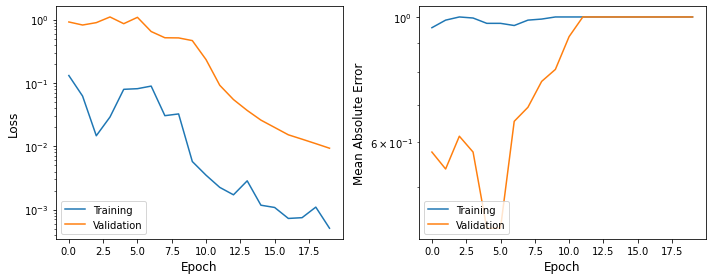

In [29]:
# plot training

fig, axes = plt.subplots(1,2,figsize=(10, 4))

axes[0].semilogy(history.epoch, history.history['loss'], label='Training')
axes[0].semilogy(history.epoch, history.history['val_loss'], label='Validation')
axes[0].legend(loc='lower left')
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_xlabel('Epoch', fontsize=12)

axes[1].semilogy(history.epoch, history.history['accuracy'], label='Training')
axes[1].semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
axes[1].legend(loc='lower left')
axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1].set_xlabel('Epoch', fontsize=12)

plt.tight_layout()
plt.show()

# Test

In [30]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Tanimoto similarity imports
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, MolToSmiles, RDKFingerprint
from rdkit.Chem import Descriptors, QED, rdmolops

ModuleNotFoundError: No module named 'seaborn'

In [31]:
#load model

model.load_weights(f"oneshot_model{dataid}.h5")

In [32]:
# non-test set files
import random

frags=pd.read_csv('fragments.csv')
frags['smiles_l']=frags['fragment']

#shuffle complete so fragments-complete pairs are not together

mixup=frags['complete'].tolist()
random.shuffle(smiles)#mixup)
frags['smiles_r']=smiles[:len(frags)]


frags=frags.drop(columns=['fragment','complete'],axis=1)

frags['similarity']=0.

y_test=frags['similarity'].tolist()

# make graphs
frags['nx_l'] = frags['smiles_l'].apply(convert_smiles_to_nx)
frags['nx_r'] = frags['smiles_r'].apply(convert_smiles_to_nx)

def df_conversion(l, r, atom_types, bond_types):
    return convert_nxs_to_dicts(l, r, atom_types, bond_types)

frags['dict'] = frags.apply(lambda x: df_conversion(x.nx_l, x.nx_r, atom_types, bond_types), axis=1)
#data.head()
print(f'{len(frags)} pairs generated')


for path, data in zip([f'fragments.proto'], [frags]):
    with tf.io.TFRecordWriter(path) as writer:
        for _, entry in data.iterrows():
            record = entry['dict']
            record['similarity'] = entry['similarity']
            writer.write(make_tfrecord(record))
            
test_loader = make_data_loader('fragments.proto', batch_size=16, output_property='similarity')

FileNotFoundError: [Errno 2] File fragments.csv does not exist: 'fragments.csv'

In [33]:
y_preds=model.predict(test_loader)
y_preds=[float(x) for x in y_preds]
y_preds_int=[round(x) for x in y_preds]

#y_test=test_data['similarity'].tolist()
target_classes=['Different', 'Same']

In [34]:
test_data=frags

NameError: name 'frags' is not defined

In [ ]:
for i, pred in enumerate(y_preds_int):
    if pred ==0:#!= y_test[i]:
        print(test_data.iloc[i]['similarity'])
        smiles_l=test_data.iloc[i]['smiles_l']
        smiles_r=test_data.iloc[i]['smiles_r']
        print(f'  TS Similarity: {round(round(test_data.iloc[i]["TS"],3),3)}')
        print(f'  Predicted Similarity: {round(test_data.iloc[i]["similarity_pred"],3)}')
        print(f'  {smiles_l}')
        print(f'  {smiles_r}')
        

In [35]:
def calc_TS(row):
    fps_l = RDKFingerprint(MolFromSmiles(row['smiles_l']))
    fps_r = RDKFingerprint(MolFromSmiles(row['smiles_r']))
    return DataStructs.FingerprintSimilarity(fps_l, fps_r)
    
test_data['similarity_pred']=y_preds
test_data['similarity_match']=y_preds_int
test_data['TS'] = test_data.apply(calc_TS, axis=1)


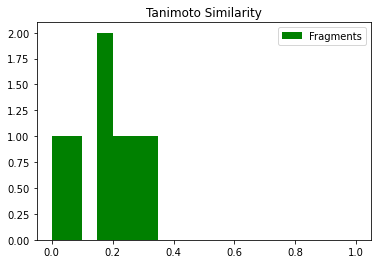

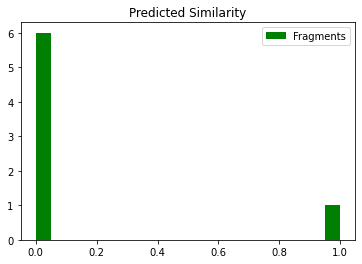

In [36]:
bins=[x/20 for x in list(range(0,21))]

plt.hist(test_data.loc[test_data['similarity']==0]['TS'], bins=bins, label='Fragments', color='green')
#plt.hist(test_data.loc[test_data['similarity']==1]['TS'], bins=bins, label='Similar', alpha=0.8)
plt.title('Tanimoto Similarity')
plt.legend()
plt.show()

plt.hist(test_data.loc[test_data['similarity']==0]['similarity_pred'], bins=bins, label='Fragments', color='green')
#plt.hist(test_data.loc[test_data['similarity']==1]['similarity_pred'], bins=bins, label='Similar')
plt.title('Predicted Similarity')
plt.legend()
plt.show()

In [37]:
savedf=test_data.drop(columns=['dict','nx_l','nx_r','similarity','similarity_match']).copy()

savedf['N heteroatoms'] = savedf['N heavy atoms']-savedf['N carbon atoms']

param=list(savedf.columns)[-1]
plt.scatter(savedf.loc[savedf['MW']<=200][param],savedf.loc[savedf['MW']<=200]['TS'], label='Tanimoto')
plt.scatter(savedf.loc[savedf['MW']<=200][param],savedf.loc[savedf['MW']<=200]['similarity_pred'], label='Similarity')
plt.legend(ncol=1,loc='center right',fontsize=10)
plt.xlabel(param)
plt.title('MW<=200')
plt.show()

plt.hist(savedf['MW'],bins=list(range(0,500,50)))
plt.xlabel('Molecular Weight')
plt.show()

KeyError: 'N heavy atoms'

In [38]:
print(classification_report(y_test, y_preds_int, target_names=target_classes))

NameError: name 'y_test' is not defined

In [ ]:
#plot confusion matrix
cm=confusion_matrix(y_test,y_preds_int)
df_cm = pd.DataFrame(cm, index = target_classes, columns = target_classes)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, vmin=0, vmax=int(len(y_test)/2), fmt='g')
#plt.savefig('cm.png')
plt.show()

In [ ]:
# ROC curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_preds, drop_intermediate=False)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(6, 5))
plt.plot(fpr_keras, tpr_keras, label='Test (AUC = {:.3f}'.format(auc_keras)+')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('ROC.png', dpi=300)
plt.show()